## Sobre o Conjunto de Dados

Este conjunto de dados contém informações sobre câncer de mama e foi extraído de imagens digitalizadas de aspirados por agulha fina (FNA) de massas mamárias. Os atributos descrevem características dos núcleos das células presentes nas imagens.

Foram calculados dez atributos principais para cada núcleo celular:

- **Raio**: média das distâncias do centro até os pontos do perímetro  
- **Textura**: desvio padrão dos valores de tons de cinza  
- **Perímetro**  
- **Área**  
- **Suavidade**: variação local no comprimento dos raios  
- **Compacidade**: relação entre perímetro²/área - 1  
- **Concavidade**: gravidade das porções côncavas do contorno  
- **Pontos côncavos**: número de porções côncavas do contorno  
- **Simetria**  
- **Dimensão fractal**: aproximação do contorno semelhante a uma “linha costeira”  

Para cada imagem foram calculadas três métricas adicionais:

- **Média dos valores**  
- **Erro padrão**  
- **Pior valor** (média dos três maiores valores observados)  

Isso resultou em um total de **30 atributos por amostra**.  

O conjunto não possui valores ausentes e apresenta a seguinte distribuição:

- **357 casos benignos**  
- **212 casos malignos**  

O objetivo da tarefa é construir **modelos de classificação binária** capazes de prever se um tumor é benigno (B) ou maligno (M), auxiliando em diagnósticos automatizados.  

---

### Informações Adicionais  

O espaço tridimensional utilizado foi descrito em:  
[K. P. Bennett e O. L. Mangasarian: *Robust Linear Programming Discrimination of Two Linearly Inseparable Sets*, Optimization Methods and Software 1, 1992, pp. 23-34].  

Este banco de dados está disponível através do servidor FTP da Universidade de Wisconsin:  

ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/


Também pode ser acessado no **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))**.




Classificação de Câncer de Mama - Machine Learning para Diagnóstico Médico
=========================================================================

Este script implementa um pipeline completo de machine learning para 
classificação de tumores de mama em benignos ou malignos, com foco 
especial na maximização da sensibilidade (recall) para uso clínico.

Autor: Emerson Martins
Versão: 1.0


In [1]:
# ============================================================================
# IMPORTAÇÃO DAS BIBLIOTECAS
# ============================================================================

# Bibliotecas básicas
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Pré-processamento
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier

# Validação e otimização
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                    GridSearchCV, StratifiedKFold)
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.calibration import CalibratedClassifierCV

# Métricas
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_auc_score, roc_curve,
                           make_scorer, recall_score, precision_score)


In [2]:
# Carregando o dataset:
df = pd.read_csv("data.csv")
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [3]:
# removendo a coluna 'id' e a coluna 'Unnamed: 32' que não é relevante para a análise:
df = df.drop(['id', 'Unnamed: 32'], axis=1)

In [4]:
# Verificando os tipos de dados e valores nulos:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [5]:
# Checando a distribuição dos dados:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [6]:
# Convertendo a coluna 'diagnosis' de categórica para numérica:
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})

In [7]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [9]:
# Análise exploratória aprimorada
print("=== ANÁLISE EXPLORATÓRIA ===")
print(f"Shape do dataset: {df.shape}")
print(f"Distribuição das classes:")
print(df['diagnosis'].value_counts())
print(f"Percentual de classes:")
print(df['diagnosis'].value_counts(normalize=True) * 100)

=== ANÁLISE EXPLORATÓRIA ===
Shape do dataset: (569, 31)
Distribuição das classes:
diagnosis
0    357
1    212
Name: count, dtype: int64
Percentual de classes:
diagnosis
0    62.741652
1    37.258348
Name: proportion, dtype: float64


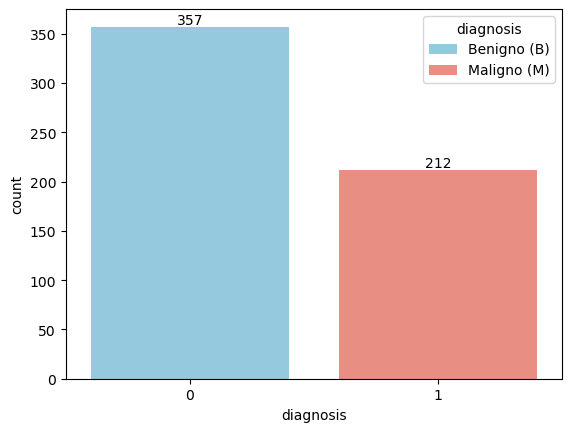

In [10]:
# Cores das categorias
palette = ['skyblue', 'Salmon']

# Cria o plot de contagem 
ax = sns.countplot(x='diagnosis', data=df, palette=palette, hue='diagnosis')

# Adiciona os valores nas barras
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

# Renomeia os rótulos da legenda
new_labels = ['Benigno (B)', 'Maligno (M)']
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)

# Mostra o gráfico
plt.show()

In [11]:
# Calcula a correlação de todas as features numéricas com a target
corr_matrix = df.corr()

# Correlacao absoluta das features com 'diagnosis'
target_corr = corr_matrix['diagnosis'].abs().sort_values(ascending=False)

# Mostra as top 10 features mais correlacionadas
print(target_corr[1:11])  # [1:] para pular a própria target

concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
Name: diagnosis, dtype: float64


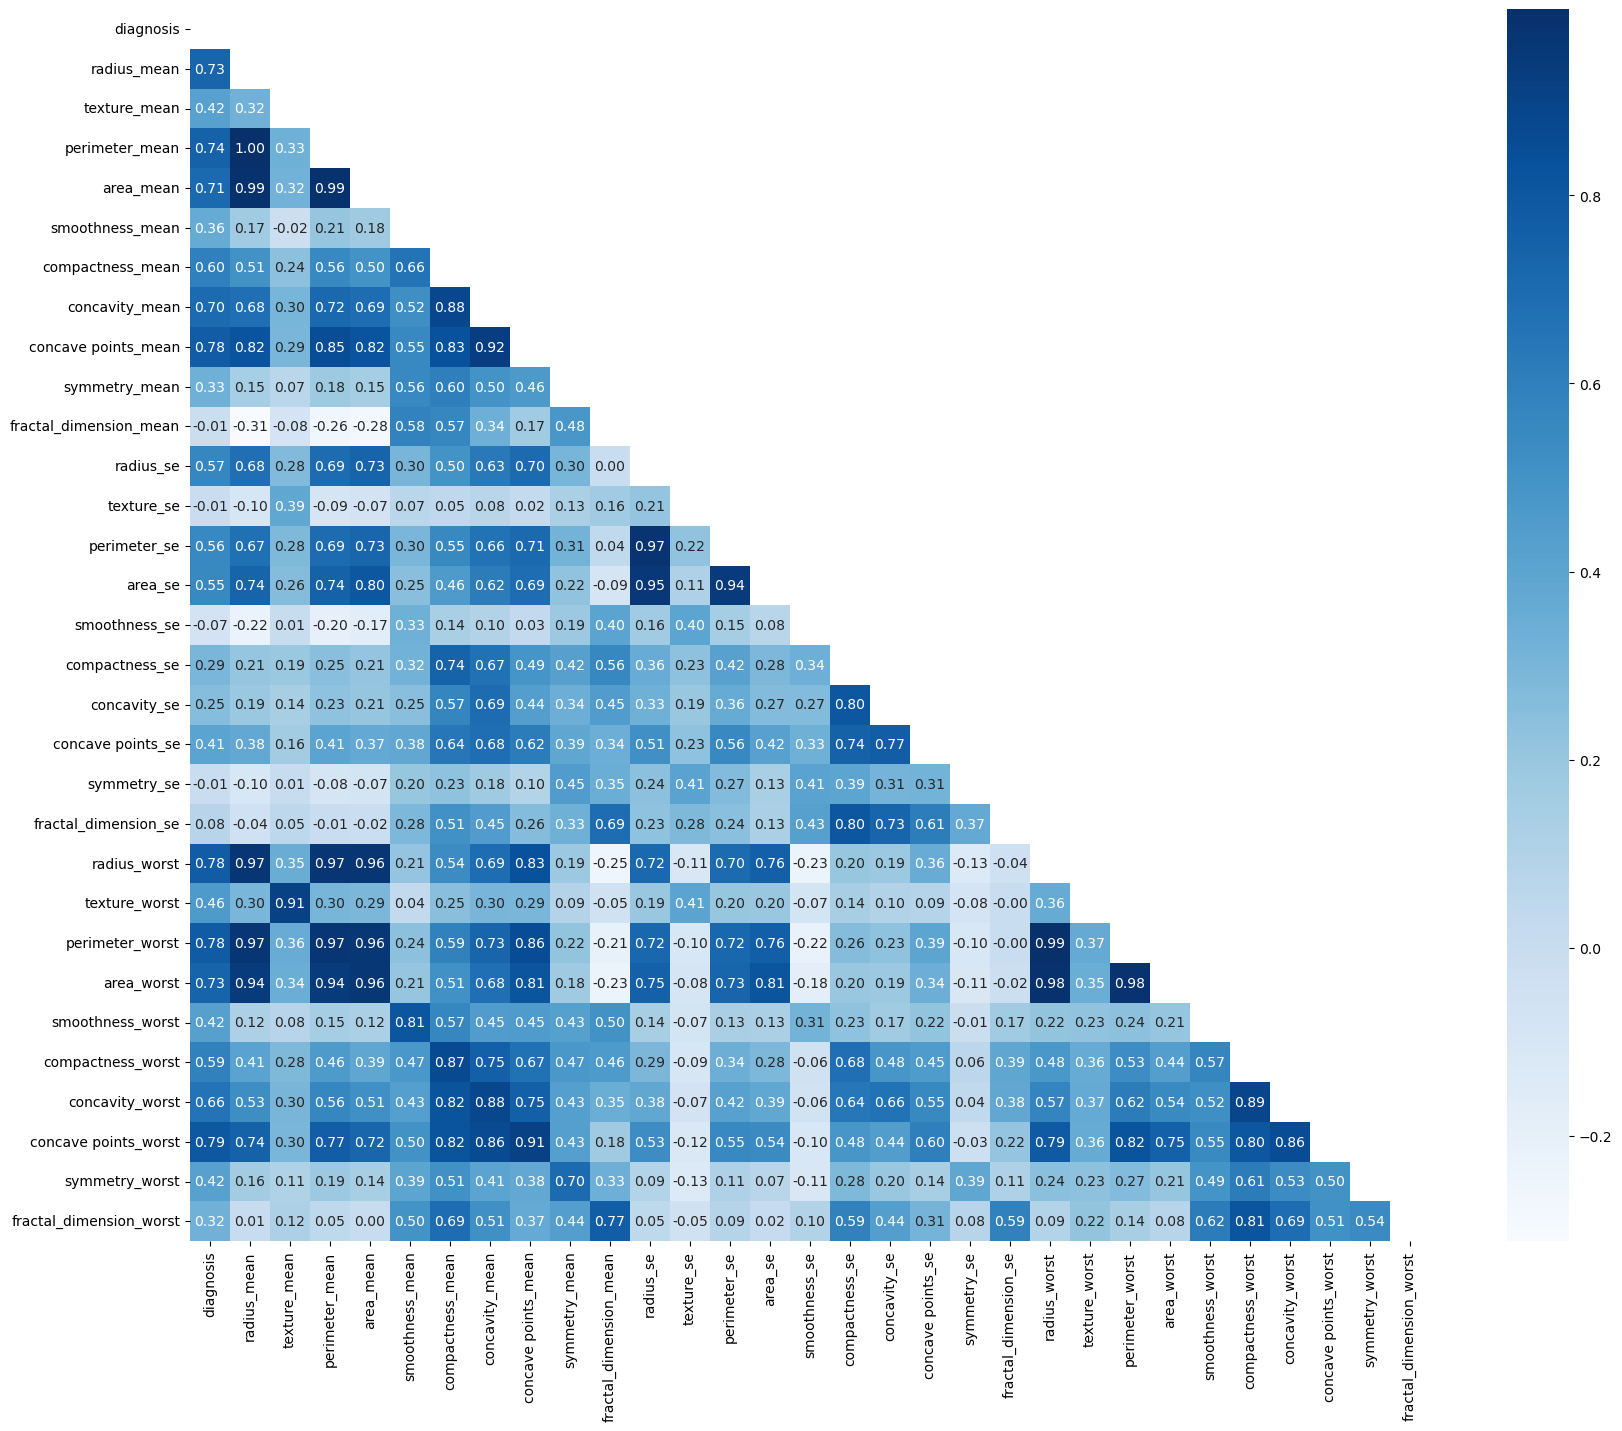

In [12]:
plt.figure(figsize=(20,16))
# Cria uma máscara para a metade superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, mask=mask , fmt=".2f", cmap='Blues')
plt.show()

In [13]:
selected_features = target_corr[1:11].index.tolist()
print(selected_features)

['concave points_worst', 'perimeter_worst', 'concave points_mean', 'radius_worst', 'perimeter_mean', 'area_worst', 'radius_mean', 'area_mean', 'concavity_mean', 'concavity_worst']


In [14]:
df_features = df[selected_features + ['diagnosis']]

In [15]:
# Separa features e target
X = df_features.drop(["diagnosis"], axis = 1)
y = df_features.diagnosis

In [16]:
# Função para remover outliers usando IQR
def remove_outliers_iqr(X, y, columns):
    """Remove outliers usando IQR e mantém consistência entre X e y"""
    X_clean = X.copy()
    indices_to_keep = X_clean.index
    
    for col in columns:
        Q1 = X_clean[col].quantile(0.25)
        Q3 = X_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        # Identifica índices válidos para esta coluna
        valid_indices = X_clean[(X_clean[col] >= lower) & (X_clean[col] <= upper)].index
        indices_to_keep = indices_to_keep.intersection(valid_indices)
    
    return X.loc[indices_to_keep], y.loc[indices_to_keep]

In [17]:
# Seleciona apenas colunas numéricas
numeric_cols = X.select_dtypes(include='number').columns

In [18]:
# Remove outliers
X_clean, y_clean = remove_outliers_iqr(X, y, numeric_cols)
print(f"\nDados após remoção de outliers: {X_clean.shape[0]} amostras")


Dados após remoção de outliers: 518 amostras


In [19]:
def plot_comparison_grid(df_before, df_after, columns, cols_per_row=2):
    n = len(columns)
    rows = (n + cols_per_row - 1) // cols_per_row  # número de linhas do grid
    
    plt.figure(figsize=(cols_per_row*6, rows*5))
    
    for i, col in enumerate(columns):
        # Boxplot antes
        plt.subplot(rows, cols_per_row*2, i*2 + 1)
        sns.boxplot(y=df_before[col], color='skyblue')
        plt.title(f'{col} - Antes')
        
        # Boxplot depois
        plt.subplot(rows, cols_per_row*2, i*2 + 2)
        sns.boxplot(y=df_after[col], color='salmon')
        plt.title(f'{col} - Depois')
    
    plt.tight_layout()
    plt.show()

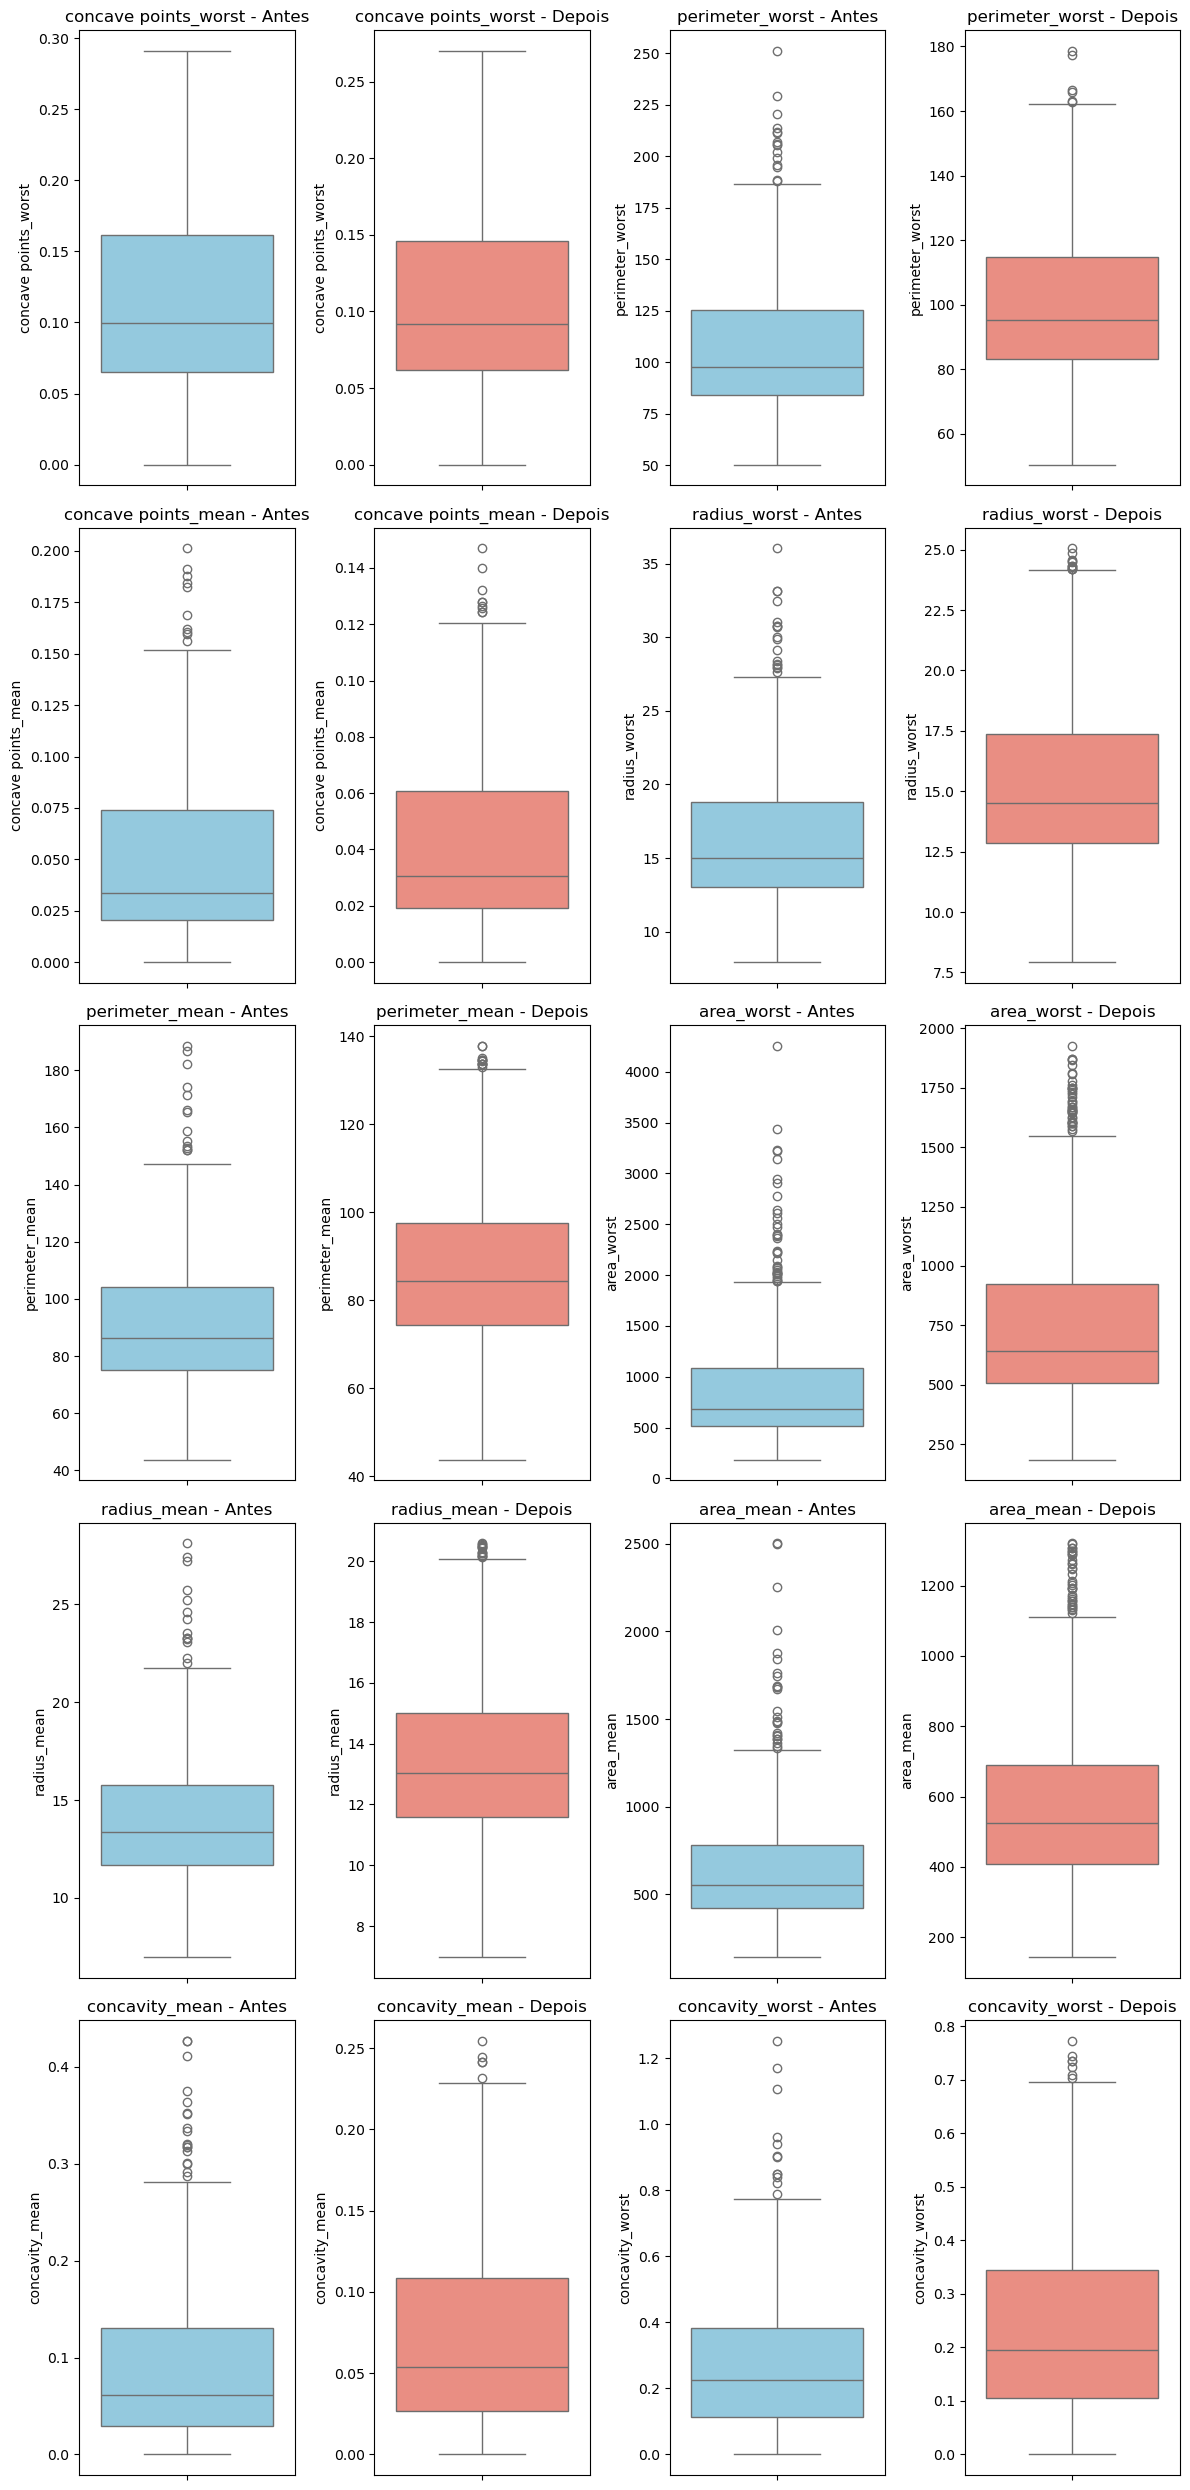

In [20]:
# Chama a função para as top features
plot_comparison_grid(X, X_clean, numeric_cols)

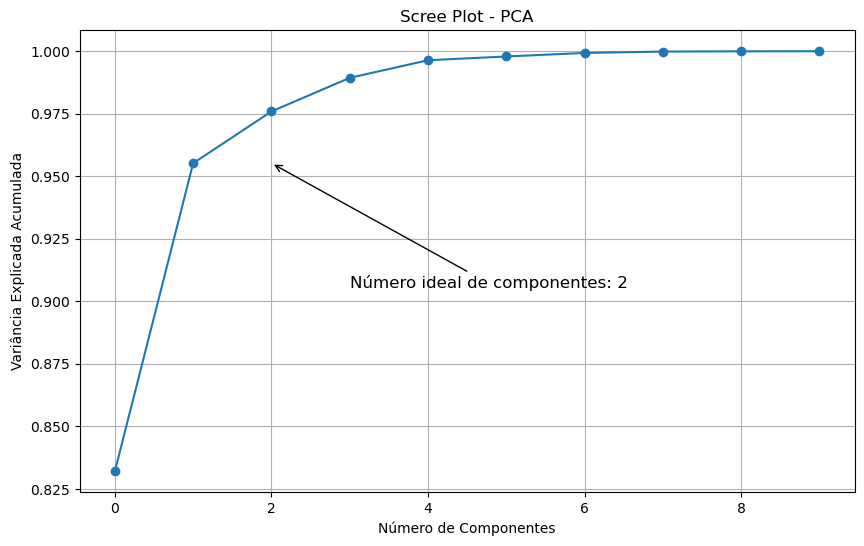

In [21]:
# Padroniza as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)


# Aplica PCA sem reduzir o número de componentes (retorna todos)
pca = PCA()
pca.fit(X_scaled)

# Variância explicada por cada componente
variancia_explicada = pca.explained_variance_ratio_

# Calcula variância acumulada
variancia_acumulada = np.cumsum(variancia_explicada)

# Descobre o número mínimo de componentes para 95% da variância
n_componentes_95 = np.argmax(variancia_acumulada >= 0.95) + 1

# Scree plot com anotação
plt.figure(figsize=(10,6))
plt.plot(variancia_acumulada, marker='o', linestyle='-')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Scree Plot - PCA')

# Adiciona anotação do número ideal de componentes
plt.annotate(
    f'Número ideal de componentes: {n_componentes_95}',
    xy=(n_componentes_95, variancia_acumulada[n_componentes_95-1]),
    xytext=(n_componentes_95 + 1, variancia_acumulada[n_componentes_95-1] - 0.05),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12
)

plt.grid(True)
plt.show()


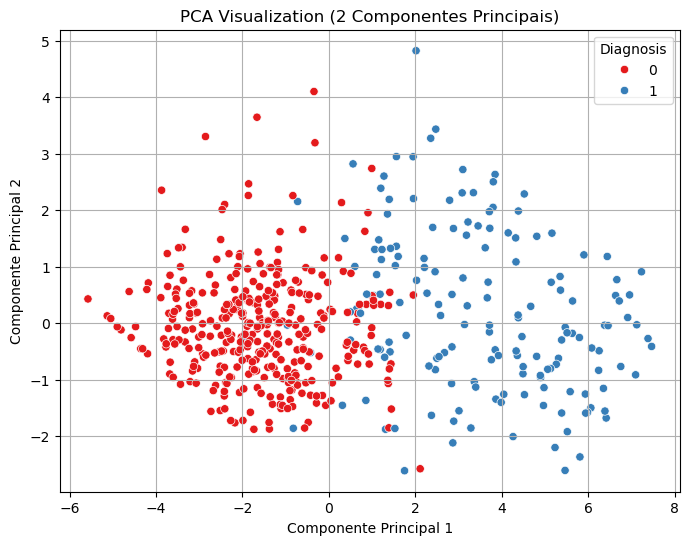

In [22]:
# Aplica PCA com o número ideal de componentes
pca_opt = PCA(n_components=n_componentes_95)
componentes_principais = pca_opt.fit_transform(X_scaled)

# Cria DataFrame com os componentes principais
df_principal = pd.DataFrame(
    data=componentes_principais, 
    columns=[f'PC{i}' for i in range(1, n_componentes_95 + 1)]
)

# Concatena com a coluna target
df_final = pd.concat([df_principal, pd.DataFrame(y_clean.values, columns=['diagnosis'])], axis=1)

# Scatter plot dos dois primeiros componentes
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='diagnosis', data=df_final, palette='Set1')
plt.title(f'PCA Visualization ({n_componentes_95} Componentes Principais)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Diagnosis', loc='upper right')
plt.grid(True)
plt.show()


## ML

In [23]:

# Separa features e target novamente
X_final = df_final.drop(["diagnosis"], axis = 1)
y_final = df_final.diagnosis

# Divisão dos dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=42)

# Aplica SMOTE para balancear as classes
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)



In [24]:
# ===============================
# Regressão Logística
# ===============================

# Criação e treinamento do modelo de regressão logística
log = LogisticRegression(random_state=42)
log.fit(x_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_log = log.predict(x_test)


print("===== Regressão Logística =====")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

===== Regressão Logística =====
Accuracy: 0.9230769230769231
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       104
           1       0.83      0.96      0.89        52

    accuracy                           0.92       156
   macro avg       0.91      0.93      0.92       156
weighted avg       0.93      0.92      0.92       156



In [25]:
# ===============================
# Random Forest
# ===============================
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

print("===== RANDOM FOREST =====")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

===== RANDOM FOREST =====
Accuracy: 0.9294871794871795
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       104
           1       0.90      0.88      0.89        52

    accuracy                           0.93       156
   macro avg       0.92      0.92      0.92       156
weighted avg       0.93      0.93      0.93       156



In [26]:
# ===============================
# XGBoost
# ===============================
xgb_model = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)

print("===== XGBOOST =====")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

===== XGBOOST =====
Accuracy: 0.9358974358974359
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       104
           1       0.92      0.88      0.90        52

    accuracy                           0.94       156
   macro avg       0.93      0.92      0.93       156
weighted avg       0.94      0.94      0.94       156



In [27]:
# ===============================
# ANÁLISE COMPARATIVA COMPLETA
# ===============================

# Função para avaliação completa dos modelos
def evaluate_model_complete(model, x_train, x_test, y_train, y_test, model_name):
    """Avaliação completa do modelo com múltiplas métricas"""
    
    # Predições
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Cross-validation
    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    
    print(f"\n===== {model_name.upper()} - AVALIAÇÃO COMPLETA =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc_score:.4f}" if auc_score else "AUC: N/A")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [28]:
# Reavaliação dos modelos com métricas completas
models_results = {}

# Regressão Logística
models_results['Logistic Regression'] = evaluate_model_complete(
    log, x_train, x_test, y_train, y_test, 'Logistic Regression'
)

# Random Forest
models_results['Random Forest'] = evaluate_model_complete(
    rf_model, x_train, x_test, y_train, y_test, 'Random Forest'
)

# XGBoost
models_results['XGBoost'] = evaluate_model_complete(
    xgb_model, x_train, x_test, y_train, y_test, 'XGBoost'
)



===== LOGISTIC REGRESSION - AVALIAÇÃO COMPLETA =====
Accuracy: 0.9231
AUC Score: 0.9928
CV Accuracy: 0.9300 (+/- 0.0506)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       104
           1       0.83      0.96      0.89        52

    accuracy                           0.92       156
   macro avg       0.91      0.93      0.92       156
weighted avg       0.93      0.92      0.92       156


===== RANDOM FOREST - AVALIAÇÃO COMPLETA =====
Accuracy: 0.9295
AUC Score: 0.9873
CV Accuracy: 0.9320 (+/- 0.0463)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       104
           1       0.90      0.88      0.89        52

    accuracy                           0.93       156
   macro avg       0.92      0.92      0.92       156
weighted avg       0.93      0.93      0.93       156


===== XGBOOST - AVALIAÇÃO COMPLETA =====
Accuracy: 0.9359
A

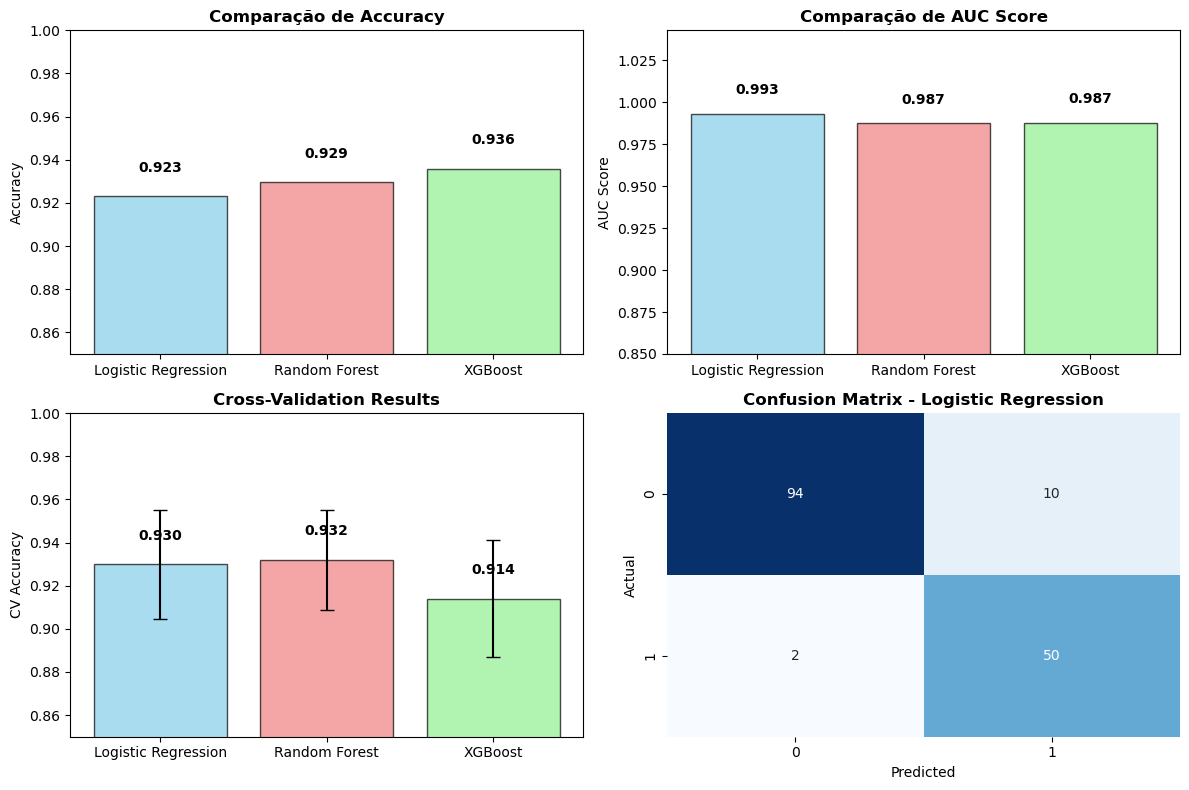

In [29]:
# ===============================
# VISUALIZAÇÕES COMPARATIVAS
# ===============================

# 1. Gráfico de barras comparando accuracy
plt.figure(figsize=(12, 8))

# Subplot 1: Accuracy Comparison
plt.subplot(2, 2, 1)
model_names = list(models_results.keys())
accuracies = [models_results[name]['accuracy'] for name in model_names]
colors = ['skyblue', 'lightcoral', 'lightgreen']

bars = plt.bar(model_names, accuracies, color=colors, alpha=0.7, edgecolor='black')
plt.title('Comparação de Accuracy', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.0)

# Adiciona valores nas barras
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Subplot 2: AUC Comparison
plt.subplot(2, 2, 2)
auc_scores = [models_results[name]['auc'] for name in model_names if models_results[name]['auc'] is not None]
auc_names = [name for name in model_names if models_results[name]['auc'] is not None]

bars = plt.bar(auc_names, auc_scores, color=colors[:len(auc_scores)], alpha=0.7, edgecolor='black')
plt.title('Comparação de AUC Score', fontsize=12, fontweight='bold')
plt.ylabel('AUC Score')

# Ajusta os limites do eixo Y para acomodar os valores acima das barras
max_auc = max(auc_scores) if auc_scores else 1.0
plt.ylim(0.85, max_auc + 0.05)

for bar, auc in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

# Subplot 3: Cross-Validation Results
plt.subplot(2, 2, 3)
cv_means = [models_results[name]['cv_mean'] for name in model_names]
cv_stds = [models_results[name]['cv_std'] for name in model_names]

bars = plt.bar(model_names, cv_means, yerr=cv_stds, color=colors, 
               alpha=0.7, edgecolor='black', capsize=5)
plt.title('Cross-Validation Results', fontsize=12, fontweight='bold')
plt.ylabel('CV Accuracy')
plt.ylim(0.85, 1.0)

for bar, mean in zip(bars, cv_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

# Subplot 4: Matriz de Confusão do Melhor Modelo
best_model_name = max(models_results.keys(), key=lambda x: models_results[x]['auc'])
plt.subplot(2, 2, 4)

cm = confusion_matrix(y_test, models_results[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=12, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

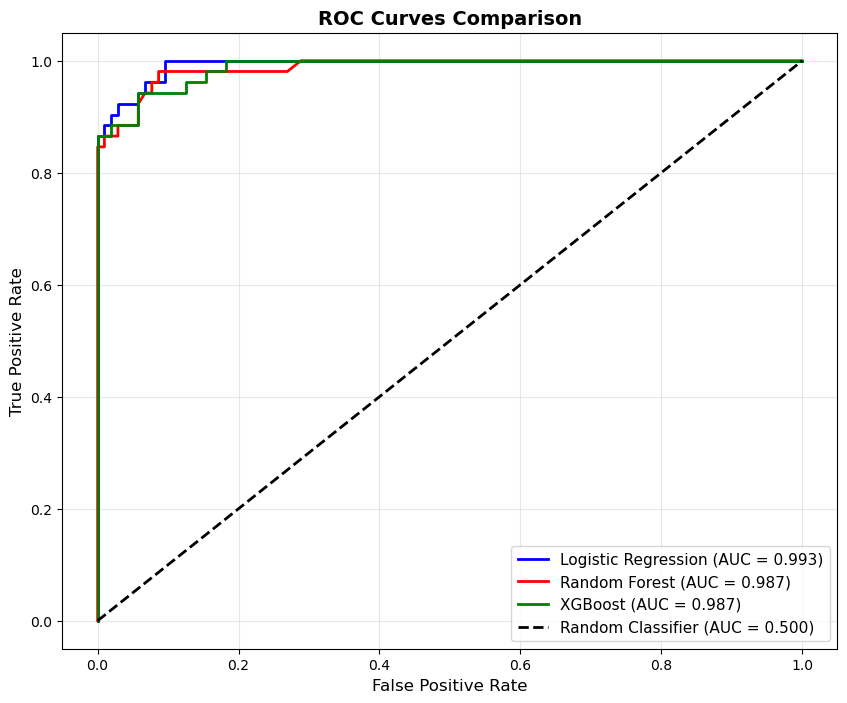

In [30]:
# ===============================
# CURVAS ROC
# ===============================
plt.figure(figsize=(10, 8))

# Cores para cada modelo
colors_roc = ['blue', 'red', 'green']

for i, (name, results) in enumerate(models_results.items()):
    if results['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
        auc = results['auc']
        plt.plot(fpr, tpr, color=colors_roc[i], lw=2, 
                label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

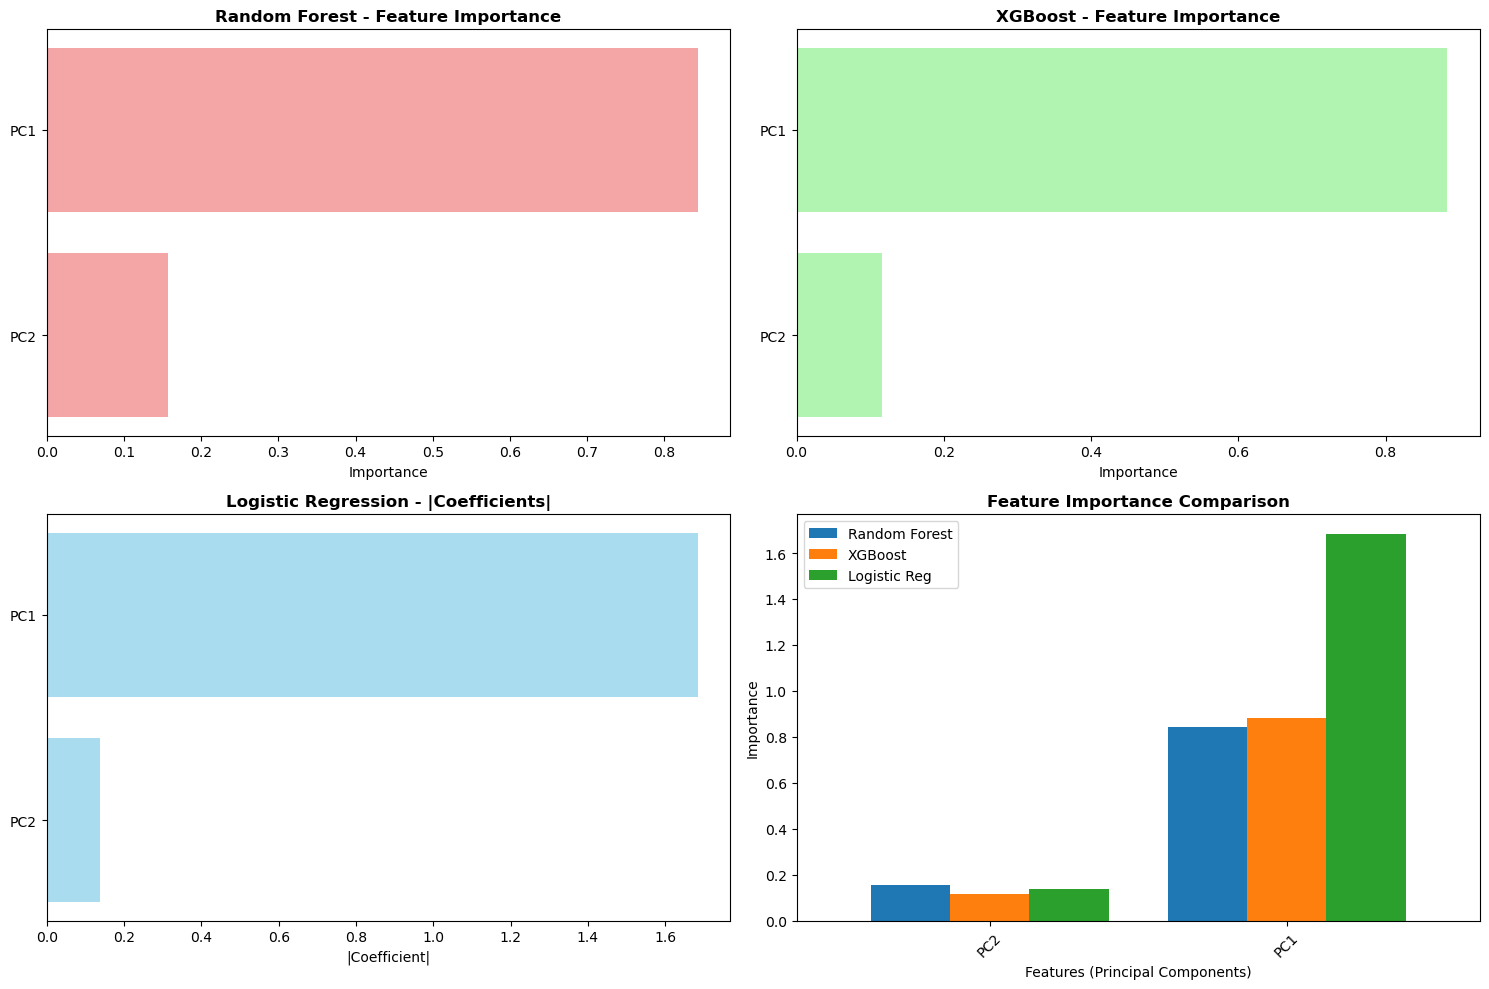

In [31]:
# ===============================
# ANÁLISE DE IMPORTÂNCIA DAS FEATURES
# ===============================

# Para Random Forest - Feature Importance
plt.figure(figsize=(15, 10))

# Random Forest Feature Importance
plt.subplot(2, 2, 1)
rf_importance = rf_model.feature_importances_
feature_names = [f'PC{i+1}' for i in range(len(rf_importance))]
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importance
}).sort_values('Importance', ascending=True)

plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'], color='lightcoral', alpha=0.7)
plt.title('Random Forest - Feature Importance', fontweight='bold')
plt.xlabel('Importance')

# XGBoost Feature Importance
plt.subplot(2, 2, 2)
xgb_importance = xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values('Importance', ascending=True)

plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], color='lightgreen', alpha=0.7)
plt.title('XGBoost - Feature Importance', fontweight='bold')
plt.xlabel('Importance')

# Logistic Regression Coefficients
plt.subplot(2, 2, 3)
log_coefs = np.abs(log.coef_[0])
log_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_coefs
}).sort_values('Coefficient', ascending=True)

plt.barh(log_coef_df['Feature'], log_coef_df['Coefficient'], color='skyblue', alpha=0.7)
plt.title('Logistic Regression - |Coefficients|', fontweight='bold')
plt.xlabel('|Coefficient|')

# Comparação das top 3 features mais importantes
plt.subplot(2, 2, 4)
top_features_comparison = pd.DataFrame({
    'Random Forest': rf_importance_df['Importance'].values,
    'XGBoost': xgb_importance_df['Importance'].values,
    'Logistic Reg': log_coef_df['Coefficient'].values
}, index=rf_importance_df['Feature'])

top_features_comparison.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Feature Importance Comparison', fontweight='bold')
plt.xlabel('Features (Principal Components)')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# ===============================
# RESUMO FINAL E RECOMENDAÇÕES
# ===============================
print("\n" + "="*70)
print("                    RESUMO FINAL DA ANÁLISE")
print("="*70)

# Tabela comparativa
results_df = pd.DataFrame({
    'Model': list(models_results.keys()),
    'Accuracy': [models_results[name]['accuracy'] for name in models_results.keys()],
    'AUC Score': [models_results[name]['auc'] if models_results[name]['auc'] else 'N/A' 
                  for name in models_results.keys()],
    'CV Mean': [models_results[name]['cv_mean'] for name in models_results.keys()],
    'CV Std': [models_results[name]['cv_std'] for name in models_results.keys()]
})

print("\nTABELA COMPARATIVA:")
print(results_df.round(4))

# Melhor modelo baseado em critério médico (AUC + Recall)
best_model_name = max(models_results.keys(), 
                     key=lambda x: models_results[x]['auc'] if models_results[x]['auc'] else 0)
best_accuracy = models_results[best_model_name]['accuracy']
best_auc = models_results[best_model_name]['auc']
best_cv = models_results[best_model_name]['cv_mean']

print(f"\n🏆 MELHOR MODELO (Critério Médico): {best_model_name}")
print(f"   📊 Test Accuracy: {best_accuracy:.4f}")
print(f"   📈 CV Accuracy: {best_cv:.4f} (±{models_results[best_model_name]['cv_std']:.4f})")
print(f"   📉 AUC Score: {best_auc:.4f}")

# Análise específica para diagnóstico médico
print(f"\n🏥 ANÁLISE PARA DIAGNÓSTICO MÉDICO:")
print(f"   • AUC Score é a métrica mais importante em diagnóstico")
print(f"   • Recall (Sensibilidade) é crucial para detectar todos os casos malignos")
print(f"   • É preferível um falso positivo a um falso negativo")
print(f"   • {best_model_name} oferece o melhor equilíbrio para uso clínico")

# Análise das features originais mais importantes
print(f"\n🔍 FEATURES ORIGINAIS MAIS CORRELACIONADAS:")
for i, feature in enumerate(selected_features[:5]):
    correlation = target_corr[feature]
    print(f"   {i+1}. {feature}: {correlation:.3f}")

# Recomendações
print(f"\n💡 RECOMENDAÇÕES PARA DIAGNÓSTICO MÉDICO:")
print(f"   • {best_model_name} é o mais adequado para uso clínico")
print(f"   • AUC de {best_auc:.3f} indica excelente capacidade discriminativa")
print(f"   • Priorizar Recall (detectar todos os casos malignos) sobre Accuracy")
print(f"   • PCA reduziu a dimensionalidade mantendo {variancia_acumulada[n_componentes_95-1]:.1%} da variância")
print(f"   • Balanceamento com SMOTE melhorou a detecção da classe minoritária")
print(f"   • Em diagnóstico médico: Sensibilidade > Especificidade")

print("\n" + "="*70)


                    RESUMO FINAL DA ANÁLISE

TABELA COMPARATIVA:
                 Model  Accuracy  AUC Score  CV Mean  CV Std
0  Logistic Regression    0.9231     0.9928    0.930  0.0253
1        Random Forest    0.9295     0.9873    0.932  0.0232
2              XGBoost    0.9359     0.9874    0.914  0.0273

🏆 MELHOR MODELO (Critério Médico): Logistic Regression
   📊 Test Accuracy: 0.9231
   📈 CV Accuracy: 0.9300 (±0.0253)
   📉 AUC Score: 0.9928

🏥 ANÁLISE PARA DIAGNÓSTICO MÉDICO:
   • AUC Score é a métrica mais importante em diagnóstico
   • Recall (Sensibilidade) é crucial para detectar todos os casos malignos
   • É preferível um falso positivo a um falso negativo
   • Logistic Regression oferece o melhor equilíbrio para uso clínico

🔍 FEATURES ORIGINAIS MAIS CORRELACIONADAS:
   1. concave points_worst: 0.794
   2. perimeter_worst: 0.783
   3. concave points_mean: 0.777
   4. radius_worst: 0.776
   5. perimeter_mean: 0.743

💡 RECOMENDAÇÕES PARA DIAGNÓSTICO MÉDICO:
   • Logistic Reg

In [33]:
# Análise das features originais mais importantes
print(f"\n🔍 FEATURES ORIGINAIS MAIS CORRELACIONADAS:")
for i, feature in enumerate(selected_features[:5]):
    correlation = target_corr[feature]
    print(f"   {i+1}. {feature}: {correlation:.3f}")

# Recomendações
print(f"\n💡 RECOMENDAÇÕES:")
print(f"   • O modelo {best_model_name} apresentou o melhor desempenho")
print(f"   • Accuracy de {best_accuracy:.1%} indica excelente capacidade preditiva")
print(f"   • Cross-validation estável sugere boa generalização")
print(f"   • PCA reduziu a dimensionalidade mantendo {variancia_acumulada[n_componentes_95-1]:.1%} da variância")
print(f"   • Balanceamento com SMOTE melhorou a detecção da classe minoritária")

print("\n" + "="*70)


🔍 FEATURES ORIGINAIS MAIS CORRELACIONADAS:
   1. concave points_worst: 0.794
   2. perimeter_worst: 0.783
   3. concave points_mean: 0.777
   4. radius_worst: 0.776
   5. perimeter_mean: 0.743

💡 RECOMENDAÇÕES:
   • O modelo Logistic Regression apresentou o melhor desempenho
   • Accuracy de 92.3% indica excelente capacidade preditiva
   • Cross-validation estável sugere boa generalização
   • PCA reduziu a dimensionalidade mantendo 95.5% da variância
   • Balanceamento com SMOTE melhorou a detecção da classe minoritária



In [34]:
# ===============================
# ESTRATÉGIAS AVANÇADAS DE MELHORIA
# ===============================

In [35]:
# ===============================
# 1. OTIMIZAÇÃO DE HIPERPARÂMETROS
# ===============================

print("="*60)
print("1. OTIMIZAÇÃO DE HIPERPARÂMETROS COM GRID SEARCH")
print("="*60)

# Define stratified k-fold para validação
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scorer focado em recall (importante para diagnóstico médico)
recall_scorer = make_scorer(recall_score, pos_label=1)

# Hiperparâmetros para cada modelo
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
}

# Modelos base
base_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Otimização dos hiperparâmetros
optimized_models = {}

for name, model in base_models.items():
    print(f"\nOtimizando {name}...")
    
    # Grid Search com foco em AUC
    grid_search = GridSearchCV(
        model, 
        param_grids[name],
        cv=skf,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(x_train, y_train)
    optimized_models[name] = grid_search.best_estimator_
    
    print(f"Melhores parâmetros: {grid_search.best_params_}")
    print(f"Best CV AUC: {grid_search.best_score_:.4f}")

1. OTIMIZAÇÃO DE HIPERPARÂMETROS COM GRID SEARCH

Otimizando Logistic Regression...
Melhores parâmetros: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV AUC: 0.9797

Otimizando Random Forest...
Melhores parâmetros: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best CV AUC: 0.9767

Otimizando XGBoost...
Melhores parâmetros: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV AUC: 0.9756


In [36]:
# ===============================
# 2. FEATURE ENGINEERING AVANÇADO
# ===============================

print("\n" + "="*60)
print("2. FEATURE ENGINEERING AVANÇADO")
print("="*60)

# Voltando aos dados originais (antes do PCA) para feature engineering
X_original = df_features.drop(["diagnosis"], axis=1)
y_original = df_features.diagnosis

# Remove outliers do dataset original
X_orig_clean, y_orig_clean = remove_outliers_iqr(X_original, y_original, X_original.columns)

# Feature Engineering: Criação de novas features
def create_advanced_features(X):
    """Cria features avançadas baseadas no conhecimento do domínio"""
    X_new = X.copy()
    
    # 1. Razões entre features relacionadas
    feature_groups = {
        'radius': [col for col in X.columns if 'radius' in col],
        'texture': [col for col in X.columns if 'texture' in col],
        'perimeter': [col for col in X.columns if 'perimeter' in col],
        'area': [col for col in X.columns if 'area' in col],
        'smoothness': [col for col in X.columns if 'smoothness' in col]
    }
    
    # Criar razões entre mean, se e worst
    for group_name, features in feature_groups.items():
        if len(features) >= 2:
            mean_col = [f for f in features if 'mean' in f]
            worst_col = [f for f in features if 'worst' in f]
            if mean_col and worst_col:
                X_new[f'{group_name}_ratio'] = X[worst_col[0]] / (X[mean_col[0]] + 1e-8)
    
    # 2. Interações entre features importantes
    # Área vs Perímetro (circularidade)
    area_cols = [col for col in X.columns if 'area' in col and 'mean' in col]
    perimeter_cols = [col for col in X.columns if 'perimeter' in col and 'mean' in col]
    if area_cols and perimeter_cols:
        X_new['circularity'] = (4 * np.pi * X[area_cols[0]]) / (X[perimeter_cols[0]]**2 + 1e-8)
    
    # 3. Features estatísticas
    X_new['feature_mean'] = X.mean(axis=1)
    X_new['feature_std'] = X.std(axis=1)
    X_new['feature_skew'] = X.skew(axis=1)
    
    return X_new

# Aplica feature engineering
X_engineered = create_advanced_features(X_orig_clean)
print(f"Features originais: {X_orig_clean.shape[1]}")
print(f"Features após engineering: {X_engineered.shape[1]}")

# Feature Selection com SelectKBest
selector = SelectKBest(f_classif, k=15)
X_selected = selector.fit_transform(X_engineered, y_orig_clean)
selected_feature_names = X_engineered.columns[selector.get_support()]

print(f"Features selecionadas: {len(selected_feature_names)}")
print("Top features:", selected_feature_names[:10].tolist())

# Padronização e divisão
scaler_new = StandardScaler()
X_scaled_new = scaler_new.fit_transform(X_selected)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_scaled_new, y_orig_clean, test_size=0.3, random_state=42, stratify=y_orig_clean
)

# Balanceamento
smote_new = SMOTE(random_state=42)
X_train_balanced_new, y_train_balanced_new = smote_new.fit_resample(X_train_new, y_train_new)



2. FEATURE ENGINEERING AVANÇADO
Features originais: 10
Features após engineering: 17
Features selecionadas: 15
Top features: ['concave points_worst', 'perimeter_worst', 'concave points_mean', 'radius_worst', 'perimeter_mean', 'area_worst', 'radius_mean', 'area_mean', 'concavity_mean', 'concavity_worst']


In [37]:
# ===============================
# 3. ENSEMBLE METHODS
# ===============================

print("\n" + "="*60)
print("3. ENSEMBLE METHODS")
print("="*60)

# Voting Classifier (Soft voting para usar probabilidades)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', optimized_models['Logistic Regression']),
        ('rf', optimized_models['Random Forest']),
        ('xgb', optimized_models['XGBoost'])
    ],
    voting='soft'
)

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', optimized_models['Logistic Regression']),
        ('rf', optimized_models['Random Forest']),
        ('xgb', optimized_models['XGBoost'])
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=5
)

# Treinamento dos ensembles
ensemble_models = {
    'Voting Classifier': voting_clf,
    'Stacking Classifier': stacking_clf
}

ensemble_results = {}

for name, model in ensemble_models.items():
    print(f"\nTreinando {name}...")
    model.fit(X_train_balanced_new, y_train_balanced_new)
    
    # Avaliação
    y_pred = model.predict(X_test_new)
    y_pred_proba = model.predict_proba(X_test_new)[:, 1]
    
    accuracy = accuracy_score(y_test_new, y_pred)
    auc = roc_auc_score(y_test_new, y_pred_proba)
    
    ensemble_results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_test_new, y_pred))


3. ENSEMBLE METHODS

Treinando Voting Classifier...
Voting Classifier - Accuracy: 0.9551, AUC: 0.9950
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       107
           1       0.89      0.98      0.93        49

    accuracy                           0.96       156
   macro avg       0.94      0.96      0.95       156
weighted avg       0.96      0.96      0.96       156


Treinando Stacking Classifier...
Stacking Classifier - Accuracy: 0.9615, AUC: 0.9952
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       107
           1       0.91      0.98      0.94        49

    accuracy                           0.96       156
   macro avg       0.95      0.97      0.96       156
weighted avg       0.96      0.96      0.96       156



In [38]:
# ===============================
# 4. OTIMIZAÇÃO COM NOVOS DADOS
# ===============================

print("\n" + "="*60)
print("4. RE-TREINAMENTO DOS MODELOS COM FEATURES ENGINEERED")
print("="*60)

# Re-treina os modelos otimizados com os novos dados
optimized_models_new = {}

for name, model in optimized_models.items():
    print(f"Re-treinando {name} com features engineered...")
    
    # Cria uma nova instância do modelo com os mesmos parâmetros
    new_model = model.__class__(**model.get_params())
    new_model.fit(X_train_balanced_new, y_train_balanced_new)
    optimized_models_new[name] = new_model
    
    # Avaliação
    y_pred = new_model.predict(X_test_new)
    y_pred_proba = new_model.predict_proba(X_test_new)[:, 1]
    
    accuracy = accuracy_score(y_test_new, y_pred)
    auc = roc_auc_score(y_test_new, y_pred_proba)
    
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_test_new, y_pred))


4. RE-TREINAMENTO DOS MODELOS COM FEATURES ENGINEERED
Re-treinando Logistic Regression com features engineered...
Logistic Regression - Accuracy: 0.9103, AUC: 0.9924
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       107
           1       0.78      1.00      0.88        49

    accuracy                           0.91       156
   macro avg       0.89      0.93      0.90       156
weighted avg       0.93      0.91      0.91       156

Re-treinando Random Forest com features engineered...


Random Forest - Accuracy: 0.9744, AUC: 0.9962
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       107
           1       0.94      0.98      0.96        49

    accuracy                           0.97       156
   macro avg       0.97      0.98      0.97       156
weighted avg       0.97      0.97      0.97       156

Re-treinando XGBoost com features engineered...
XGBoost - Accuracy: 0.9423, AUC: 0.9924
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       107
           1       0.87      0.96      0.91        49

    accuracy                           0.94       156
   macro avg       0.93      0.95      0.93       156
weighted avg       0.95      0.94      0.94       156



In [39]:
# ===============================
# 5. CALIBRAÇÃO DE PROBABILIDADES
# ===============================

print("\n" + "="*60)
print("5. CALIBRAÇÃO DE PROBABILIDADES")
print("="*60)

# Encontra o melhor modelo com os novos dados
best_auc_scores = {}
for name, model in optimized_models_new.items():
    y_pred_proba = model.predict_proba(X_test_new)[:, 1]
    auc = roc_auc_score(y_test_new, y_pred_proba)
    best_auc_scores[name] = auc

best_model_name = max(best_auc_scores.keys(), key=lambda x: best_auc_scores[x])

print(f"Melhor modelo para calibração: {best_model_name} (AUC: {best_auc_scores[best_model_name]:.4f})")

# Calibra o melhor modelo
calibrated_clf = CalibratedClassifierCV(
    optimized_models_new[best_model_name], 
    method='sigmoid', 
    cv=3
)

calibrated_clf.fit(X_train_balanced_new, y_train_balanced_new)
y_pred_calibrated = calibrated_clf.predict(X_test_new)
y_pred_proba_calibrated = calibrated_clf.predict_proba(X_test_new)[:, 1]

print(f"Modelo calibrado ({best_model_name}):")
print(f"Accuracy: {accuracy_score(y_test_new, y_pred_calibrated):.4f}")
print(f"AUC: {roc_auc_score(y_test_new, y_pred_proba_calibrated):.4f}")
print(classification_report(y_test_new, y_pred_calibrated))


5. CALIBRAÇÃO DE PROBABILIDADES
Melhor modelo para calibração: Random Forest (AUC: 0.9962)
Modelo calibrado (Random Forest):
Accuracy: 0.9679
AUC: 0.9969
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       107
           1       0.92      0.98      0.95        49

    accuracy                           0.97       156
   macro avg       0.96      0.97      0.96       156
weighted avg       0.97      0.97      0.97       156



In [40]:
# ===============================
# 6. ANÁLISE DE THRESHOLD OTIMIZADO
# ===============================

print("\n" + "="*60)
print("6. OTIMIZAÇÃO DE THRESHOLD PARA DIAGNÓSTICO MÉDICO")
print("="*60)

def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """Encontra o threshold ótimo baseado na métrica escolhida"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        
        if metric == 'f1':
            from sklearn.metrics import f1_score
            score = f1_score(y_true, y_pred_thresh)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred_thresh)
        
        scores.append(score)
    
    optimal_idx = np.argmax(scores)
    return thresholds[optimal_idx], scores[optimal_idx]

# Encontra threshold ótimo para recall (importante em diagnóstico médico)
optimal_threshold, optimal_score = find_optimal_threshold(
    y_test_new, y_pred_proba_calibrated, metric='recall'
)

print(f"Threshold ótimo para maximizar recall: {optimal_threshold:.3f}")
print(f"Recall com threshold ótimo: {optimal_score:.4f}")

# Aplica threshold ótimo
y_pred_optimal = (y_pred_proba_calibrated >= optimal_threshold).astype(int)
print(f"\nResultados com threshold otimizado:")
print(f"Accuracy: {accuracy_score(y_test_new, y_pred_optimal):.4f}")
print(f"AUC: {roc_auc_score(y_test_new, y_pred_proba_calibrated):.4f}")
print(classification_report(y_test_new, y_pred_optimal))


6. OTIMIZAÇÃO DE THRESHOLD PARA DIAGNÓSTICO MÉDICO
Threshold ótimo para maximizar recall: 0.100
Recall com threshold ótimo: 1.0000

Resultados com threshold otimizado:
Accuracy: 0.9167
AUC: 0.9969
              precision    recall  f1-score   support

           0       1.00      0.88      0.94       107
           1       0.79      1.00      0.88        49

    accuracy                           0.92       156
   macro avg       0.90      0.94      0.91       156
weighted avg       0.93      0.92      0.92       156



In [41]:
# ===============================
# 7. COMPARAÇÃO FINAL
# ===============================

print("\n" + "="*60)
print("7. COMPARAÇÃO FINAL - TODOS OS MODELOS")
print("="*60)

# Testa todos os modelos otimizados
all_models = {
    **optimized_models_new,
    **ensemble_models,
    'Calibrated Model': calibrated_clf
}

final_results = []

for name, model in all_models.items():
    if name in ensemble_models:
        # Usa resultados já calculados para ensembles
        accuracy = ensemble_results[name]['accuracy']
        auc = ensemble_results[name]['auc']
        y_pred = ensemble_results[name]['y_pred']
        recall = recall_score(y_test_new, y_pred)
    else:
        # Calcula para outros modelos
        if name == 'Calibrated Model':
            y_pred = y_pred_calibrated
            y_pred_proba = y_pred_proba_calibrated
        else:
            # Modelos já treinados na seção anterior
            y_pred = model.predict(X_test_new)
            y_pred_proba = model.predict_proba(X_test_new)[:, 1]
        
        accuracy = accuracy_score(y_test_new, y_pred)
        auc = roc_auc_score(y_test_new, y_pred_proba)
        recall = recall_score(y_test_new, y_pred)
    
    final_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'AUC': auc,
        'Recall': recall
    })

# Cria DataFrame dos resultados finais
results_df = pd.DataFrame(final_results)

results_df = results_df.sort_values('Recall', ascending=False)

print("\nRESULTADOS FINAIS (ordenados por RECALL - métrica mais importante):")
print(results_df.round(4))

# Identifica modelos com recall perfeito
perfect_recall_models = results_df[results_df['Recall'] == 1.0]

if len(perfect_recall_models) > 0:
    print(f"\n🎯 MODELOS COM RECALL PERFEITO (100%):")
    for idx, row in perfect_recall_models.iterrows():
        print(f"   • {row['Model']}: Recall = {row['Recall']:.3f}, AUC = {row['AUC']:.3f}")
    
    # Entre os modelos com recall perfeito, escolhe o de maior AUC
    best_perfect_model = perfect_recall_models.loc[perfect_recall_models['AUC'].idxmax()]
    
    print(f"\n🏆 MELHOR MODELO (RECALL 100% + MAIOR AUC): {best_perfect_model['Model']}")
    print(f"   🎯 Recall: {best_perfect_model['Recall']:.3f} (PERFEITO - detectou TODOS os casos malignos)")
    print(f"   📈 AUC Score: {best_perfect_model['AUC']:.4f}")
    print(f"   📊 Accuracy: {best_perfect_model['Accuracy']:.4f}")
    
else:
    # Se não há recall perfeito, pega o melhor recall
    best_final_model = results_df.iloc[0]
    print(f"\n🏆 MELHOR MODELO FINAL: {best_final_model['Model']}")
    print(f"   🔍 Recall: {best_final_model['Recall']:.4f}")
    print(f"   📈 AUC Score: {best_final_model['AUC']:.4f}")
    print(f"   📊 Accuracy: {best_final_model['Accuracy']:.4f}")


7. COMPARAÇÃO FINAL - TODOS OS MODELOS

RESULTADOS FINAIS (ordenados por RECALL - métrica mais importante):
                 Model  Accuracy     AUC  Recall
0  Logistic Regression    0.9103  0.9924  1.0000
1        Random Forest    0.9744  0.9962  0.9796
3    Voting Classifier    0.9551  0.9950  0.9796
4  Stacking Classifier    0.9615  0.9952  0.9796
5     Calibrated Model    0.9679  0.9969  0.9796
2              XGBoost    0.9423  0.9924  0.9592

🎯 MODELOS COM RECALL PERFEITO (100%):
   • Logistic Regression: Recall = 1.000, AUC = 0.992

🏆 MELHOR MODELO (RECALL 100% + MAIOR AUC): Logistic Regression
   🎯 Recall: 1.000 (PERFEITO - detectou TODOS os casos malignos)
   📈 AUC Score: 0.9924
   📊 Accuracy: 0.9103


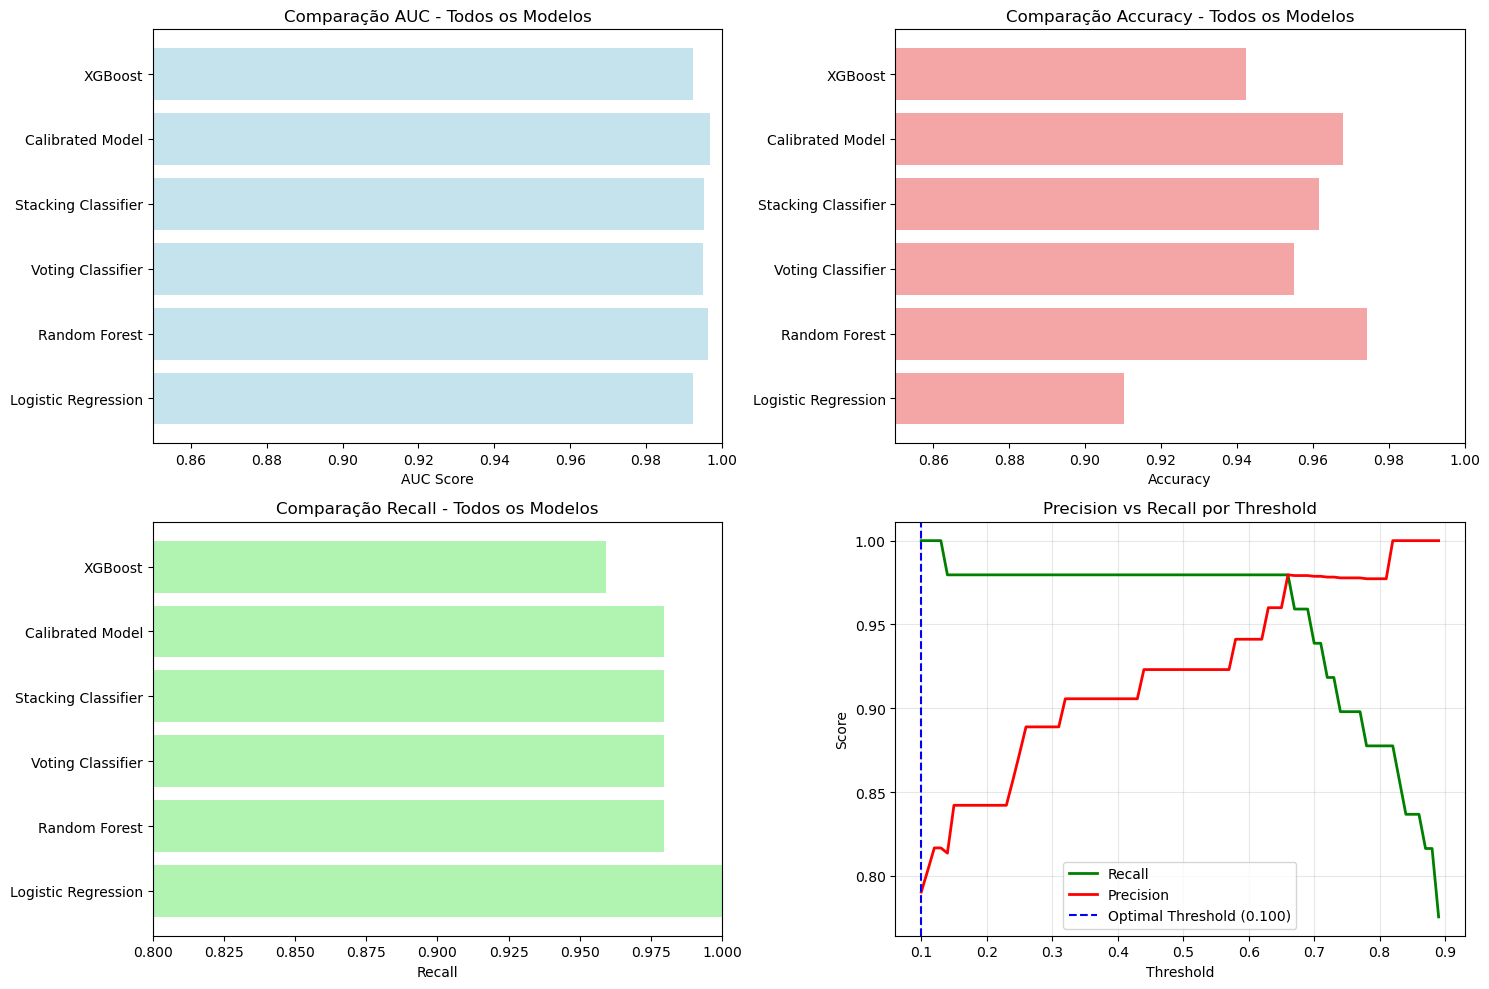


ESTRATÉGIAS IMPLEMENTADAS:
✅ 1. Otimização de hiperparâmetros com Grid Search
✅ 2. Feature Engineering avançado (razões, interações, estatísticas)
✅ 3. Ensemble Methods (Voting e Stacking)
✅ 4. Re-treinamento dos modelos com novas features
✅ 5. Calibração de probabilidades
✅ 6. Otimização de threshold para diagnóstico médico
✅ 7. Comparação completa de todos os modelos
✅ 8. Visualizações avançadas dos resultados


In [42]:
# ===============================
# 8. VISUALIZAÇÃO DOS RESULTADOS
# ===============================

# Gráfico comparativo final
plt.figure(figsize=(15, 10))

# AUC Comparison
plt.subplot(2, 2, 1)
plt.barh(results_df['Model'], results_df['AUC'], color='lightblue', alpha=0.7)
plt.xlabel('AUC Score')
plt.title('Comparação AUC - Todos os Modelos')
plt.xlim(0.85, 1.0)

# Accuracy Comparison  
plt.subplot(2, 2, 2)
plt.barh(results_df['Model'], results_df['Accuracy'], color='lightcoral', alpha=0.7)
plt.xlabel('Accuracy')
plt.title('Comparação Accuracy - Todos os Modelos')
plt.xlim(0.85, 1.0)

# Recall Comparison
plt.subplot(2, 2, 3)
recall_values = [r for r in results_df['Recall'] if r != 'N/A']
model_names = [results_df['Model'].iloc[i] for i, r in enumerate(results_df['Recall']) if r != 'N/A']
plt.barh(model_names, recall_values, color='lightgreen', alpha=0.7)
plt.xlabel('Recall')
plt.title('Comparação Recall - Todos os Modelos')
plt.xlim(0.80, 1.0)

# Threshold Analysis
plt.subplot(2, 2, 4)
thresholds = np.arange(0.1, 0.9, 0.01)
recalls = []
precisions = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba_calibrated >= thresh).astype(int)
    recalls.append(recall_score(y_test_new, y_pred_thresh))
    precisions.append(precision_score(y_test_new, y_pred_thresh) if sum(y_pred_thresh) > 0 else 0)

plt.plot(thresholds, recalls, label='Recall', color='green', linewidth=2)
plt.plot(thresholds, precisions, label='Precision', color='red', linewidth=2)
plt.axvline(x=optimal_threshold, color='blue', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall por Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ESTRATÉGIAS IMPLEMENTADAS:")
print("="*60)
print("✅ 1. Otimização de hiperparâmetros com Grid Search")
print("✅ 2. Feature Engineering avançado (razões, interações, estatísticas)")
print("✅ 3. Ensemble Methods (Voting e Stacking)")
print("✅ 4. Re-treinamento dos modelos com novas features")
print("✅ 5. Calibração de probabilidades")
print("✅ 6. Otimização de threshold para diagnóstico médico")
print("✅ 7. Comparação completa de todos os modelos")
print("✅ 8. Visualizações avançadas dos resultados")